In [2]:
import s3fs
import xarray as xr
import xesmf
import numpy as np

In [3]:
# USER DEFINED INPUTS!
# define the name of our S3 bucket
bucket_name = 'eis-dh-hydro/SNOWEX-HACKWEEK'

# define path to store on S3
lis_output_s3_path_time_chunk = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_rechunkedV4.d01.zarr'
lis_output_s3_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_default_chunks.d01.zarr/'

# specify filters
time_sel='2020-02-08'
lat_range = [38.8, 39.2]
lon_range = [-108.3, -107.5]
model_variable = ['SM_SWE_inst','SM_SnowDepth_inst']
dx = 0.001

In [4]:
# create S3 filesystem object
s3 = s3fs.S3FileSystem(anon=False)

# create key-value mapper for S3 object (required to read data stored on S3)
lis_output_mapper = s3.get_mapper(lis_output_s3_path)
lis_output_mapper_tc = s3.get_mapper(lis_output_s3_path_time_chunk)

# open the dataset
lis_output_ds = xr.open_zarr(lis_output_mapper, consolidated=True)
# lis_output_ds_tc = xr.open_zarr(lis_output_mapper_tc, consolidated=True)

In [5]:
lis_output_ds = lis_output_ds.sel(time=time_sel)

lis_output_ds = lis_output_ds.where((lis_output_ds.lat >=  lat_range[0]) & 
                                    (lis_output_ds.lat <= lat_range[1]) &
                                    (lis_output_ds.lon >=  lon_range[0]) &
                                    (lis_output_ds.lon <=  lon_range[1]) ,drop=True)

In [6]:
lis_output_ds = lis_output_ds.rename_dims({'east_west':'x','north_south':'y'})
ds_out = xesmf.util.grid_2d(lis_output_ds['lon'].min(),lis_output_ds['lon'].max(),dx,
                            lis_output_ds['lat'].min(),lis_output_ds['lat'].max(),dx)
regridder = xesmf.Regridder(lis_output_ds,ds_out,"bilinear")
outt = regridder(lis_output_ds[model_variable])

In [7]:
out_reproj = outt.assign_coords({'longitude':outt['lon'][0,:],'latitude':outt['lat'][:,0]})
out_reproj = out_reproj.rename({'x':'longitude','y':'latitude'})
out_reproj = out_reproj.rio.write_crs(4326)

In [8]:
from snowexsql.db import get_db # Import the function to get connect to the db
from snowexsql.conversions import query_to_geopandas # Import a useful function to format that data into a dataframe 
from datetime import date # Import some tools to build dates

from snowexsql.data import PointData # Import our class for the points table
from snowexsql.data import LayerData # Import our LayerData

import matplotlib.pyplot as plt
import utm 
from geoalchemy2.shape import to_shape
import pandas as pd
import numpy as np

In [9]:
# Connect to the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex' # This is what you will use for all of hackweek to access the db
engine, session = get_db(db_name)

In [10]:
q = session.query(LayerData).filter(LayerData.type == 'density')
df = query_to_geopandas(q, engine)

In [11]:
# Convert density to float
df['value'] = df['value'].astype(float)

In [12]:
# Calculate SWE
swe_lambda = lambda row: row['value'] * (row['depth'] - row['bottom_depth']) / (100*1000)
df['swe'] = df.apply(swe_lambda, axis=1)

In [13]:
sites = df['site_id'].unique().tolist()

# Loop over data by site and date
swe_values = []
x_values = []
y_values = []
dates_list = []

for site in sites:
    ind1 = df['site_id'] == site
    dates = df['date'][ind1].unique().tolist()

    for date in dates:
        # Grab all density at this site and date
        ind2= df['date'] == date

        profile = df[ind1 & ind2]
        # Check if there is data on this date/site
        if len(profile.index) > 0:
            swe_values.append(profile['swe'].sum())
            x_values.append(profile['geom'].iloc[0].x)
            y_values.append(profile['geom'].iloc[0].y)
            dates_list.append(date)

In [14]:
df_LayerData = pd.DataFrame(list(zip(swe_values, x_values, y_values, dates_list)),
               columns =['swe', 'x', 'y', 'date'])

In [15]:
lat_list = []
long_list = []
for i in range(len(df_LayerData)):
    coord = utm.to_latlon(df_LayerData['x'][i], df_LayerData['y'][i], 12, 'N')
    lat_list.append(coord[0])
    long_list.append(coord[1])

In [16]:
df_LayerData = pd.DataFrame(list(zip(swe_values, lat_list, long_list, dates_list)),
               columns =['Measured SWE', 'latitude', 'longitude', 'date'])

In [17]:
## All data uploading up to this point

In [18]:
def point_to_pointSWE(df,date,model_data):
    
    #Requires that model_data is already from the desired data
    
    
    df['date']=pd.to_datetime(df['date']) #convert dates to date-time format
    filtered_df = df.loc[(df['date'] == date)] #filter dataset for the desired dates
    
    #Find the model SWE values that match the point locations of the measured SWE values
    SWE_model_values = []
    for i in range(len(np.array(filtered_df.latitude))):
        swe_val = model_data.sel(latitude=np.array(filtered_df.latitude)[i], longitude=np.array(filtered_df.longitude)[i], method="nearest")
        swe_val1 = swe_val['SM_SWE_inst'] #specify that we want the SWE value contained in this data set
        SWE_SQ = swe_val1.squeeze().drop(['spatial_ref']) #get into format that can be converted to df
        SWE_model_values.append(float(SWE_SQ)) #create array of matching SWE values point
    
        
    filtered_df.insert(loc=1, column="Model SWE", value=SWE_model_values) #append this to original df
    
    return filtered_df

In [19]:
#Point to Point SWE results
comparativedf = point_to_pointSWE(df_LayerData,'2020-02-08',out_reproj)

In [20]:
comparativedf.insert(loc=0, column="Data Point Couples", value=[1,2,3,4,5,6,7,8,9,10]) #append row of numbers
comparativedf

,Data Point Couples,Measured SWE,Model SWE,latitude,longitude,date
360,1,0.808600,0.213553,39.031466,-108.191575,2020-02-08
368,2,0.594233,0.256477,39.033415,-108.184233,2020-02-08
413,3,0.462533,0.251853,39.018772,-108.182250,2020-02-08
435,4,0.408767,0.236184,39.035644,-108.203481,2020-02-08
437,5,0.393600,0.238592,39.018660,-108.197788,2020-02-08
438,6,0.569233,0.192125,39.032387,-108.180127,2020-02-08
442,7,0.418675,0.228355,39.064288,-108.220239,2020-02-08
455,8,0.444467,0.232855,39.019948,-108.203396,2020-02-08
458,9,0.527333,0.253569,39.019752,-108.181784,2020-02-08
493,10,0.372500,0.220361,39.034623,-108.221437,2020-02-08


In [21]:
swe_val = out_reproj.sel(latitude=39.035644, longitude=-108.203481, method="nearest")
float(swe_val['SM_SWE_inst'])

swe_val = out_reproj.sel(latitude=comparativedf.latitude, longitude=comparativedf.longitude, method="nearest")
swe_val

<xarray.Dataset>
Dimensions:            (latitude: 10, longitude: 10)
Coordinates:
    time               datetime64[ns] 2020-02-08
    lat                (latitude, longitude) float64 39.03 39.03 ... 39.03 39.03
    lon                (latitude, longitude) float64 -108.2 -108.2 ... -108.2
  * longitude          (longitude) float64 -108.2 -108.2 ... -108.2 -108.2
  * latitude           (latitude) float64 39.03 39.03 39.02 ... 39.02 39.03
    spatial_ref        int64 0
Data variables:
    SM_SWE_inst        (latitude, longitude) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    SM_SnowDepth_inst  (latitude, longitude) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

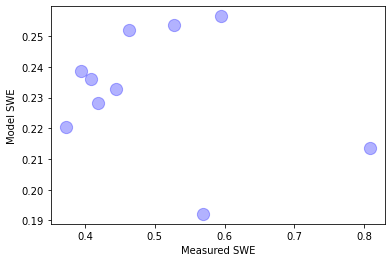

In [22]:
#Scatter Plots Comparing Values
#comparativedf.plot('Measured SWE','Model SWE',kind='scatter')
import matplotlib.pyplot as plt
 
x = comparativedf['Measured SWE']
y = comparativedf['Model SWE']
 
plt.scatter(x, y, c ="blue", alpha=0.3,s=150)
plt.xlabel('Measured SWE')
plt.ylabel('Model SWE')
#plt.title('SWE Values')

# To show the plot
plt.show()

<AxesSubplot:xlabel='Data Point Couples'>

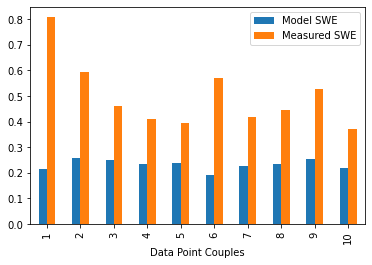

In [23]:
comparativedf.plot('Data Point Couples',['Model SWE','Measured SWE'],kind='bar')